In [2]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pathlib import Path
import pyvista as pv
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm

In [3]:
DATASET_NAME = 'RF_FULGUR_M_MESH'
DATA_PATH = Path('./OUTPUT') / DATASET_NAME
PCA_RESULTS = DATA_PATH / 'PCA_results'
PARTICLES = DATA_PATH / f'{DATASET_NAME}_default_particles'


In [4]:
def load_shapes(directory):
    shapes = []
    for filename in os.listdir(directory):
        if filename.endswith('.particles'):
            filepath = os.path.join(directory, filename)
            shape = np.loadtxt(filepath)
            shapes.append(shape)
    return shapes

def load_eigenvectors(directory):
    eigenvectors = []
    files = sorted(os.listdir(directory))
    for filename in files:
        if filename.endswith('.eig'):
            filepath = os.path.join(directory, filename)
            eigenvector = np.loadtxt(filepath)
            eigenvectors.append(eigenvector)
    return np.array(eigenvectors)

In [5]:
real_shapes = load_shapes(PARTICLES)
eigenvalues = np.loadtxt(PCA_RESULTS / 'eigenvalues.eval')
eigenvectors = load_eigenvectors(PCA_RESULTS)
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])

---
## 1. Compactness

##A. Calcul (Nous)

Nombre de composantes nécessaires pour dépasser 95% de variance cumulative : 2
Variance cumulative des 2 premières composantes : [0.91029472 0.9757956 ]


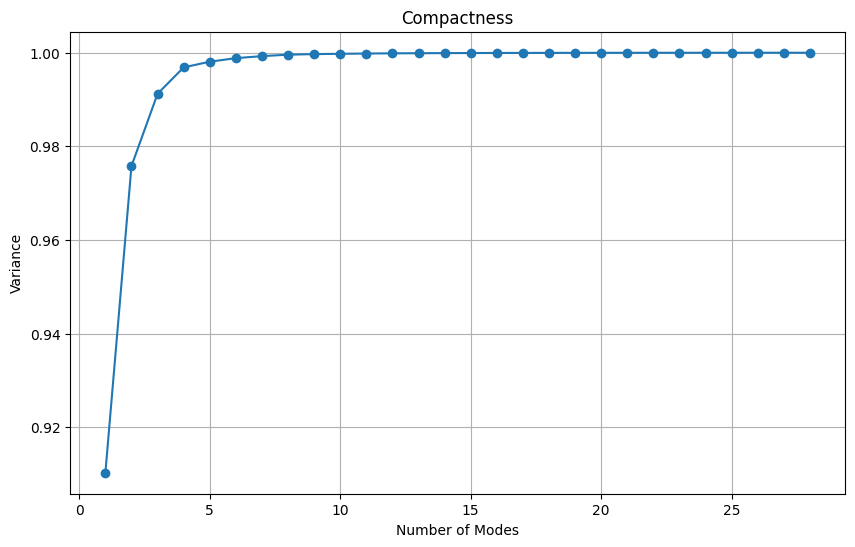

In [6]:
def compute_compactness(eigenvalues, threshold=0.95):
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    return num_components, cumulative_variance

num_components, cumulative_variance = compute_compactness(eigenvalues)

print(f"Nombre de composantes nécessaires pour dépasser {int(100 * 0.95)}% de variance cumulative : {num_components}")
print(f"Variance cumulative des {num_components} premières composantes : {cumulative_variance[:num_components]}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Modes')
plt.ylabel('Variance')
plt.title('Compactness')
plt.grid(True)
plt.show()

### B. Calcul (ShapeWorks)

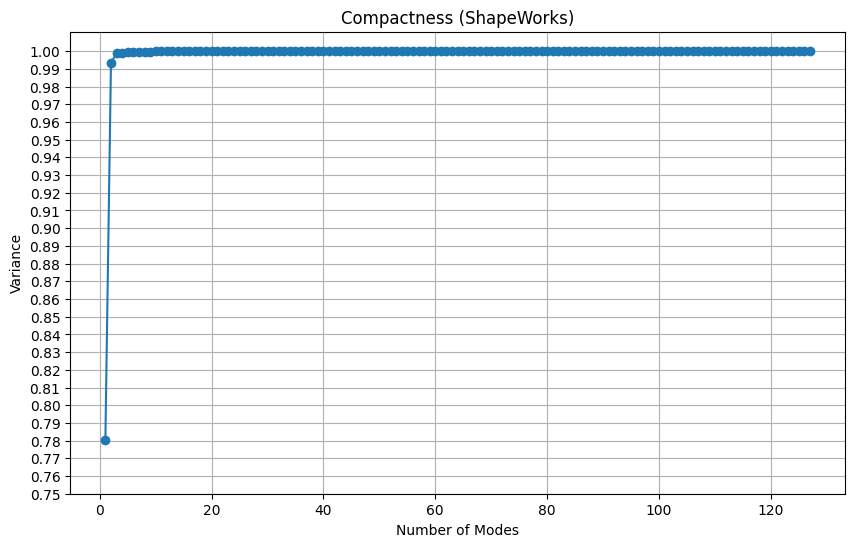

In [23]:
def compute_compactness_sw(real_shapes):
    M = np.column_stack(real_shapes)
    n = M.shape[1]
    d = M.shape[0]
    if n <= 1:
        return np.array([])
    mu = np.mean(M, axis=1, keepdims=True)
    M_centered = M - mu
    U, S, Vt = np.linalg.svd(M_centered, full_matrices=False)
    #SVD yields S as singular values -> for shapeworks: (S^2) / (n*d)
    #cumulative sum of normalized eigenvalues
    S_sq = (S**2) / (n * d)
    cumsum = np.cumsum(S_sq)
    cumsum /= cumsum[-1]  # normalize by total
    return cumsum[:-1]  # shapeworks has n-1 modes

compactness_vals = compute_compactness_sw(real_shapes)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(compactness_vals)+1), compactness_vals, marker='o', linestyle='-')
plt.xlabel('Number of Modes')
plt.ylabel('Variance')
plt.yticks(np.arange(0.75, 1.01, 0.01))
plt.title('Compactness (ShapeWorks)')
plt.grid(True)
plt.show()


---
## 2. Specificity Error

### A. Calcul (Nous)

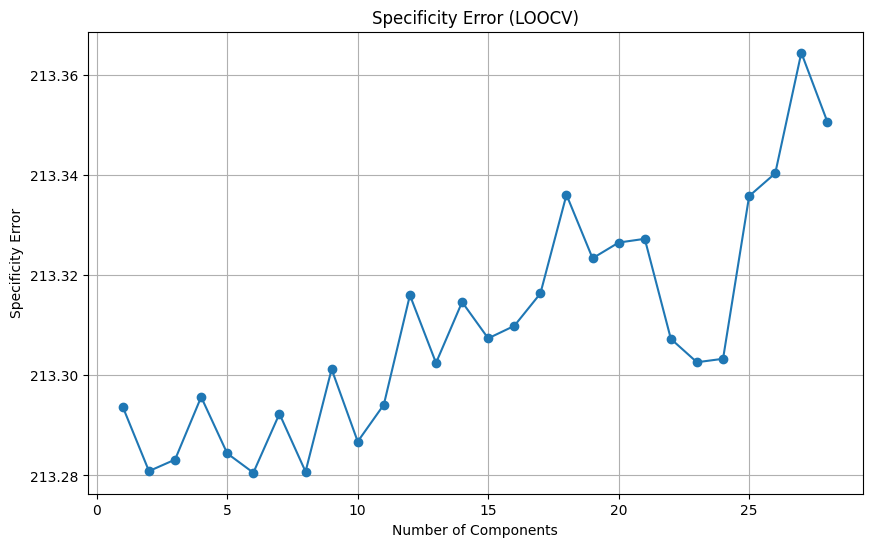

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate synthetic shapes based on PCA
def generate_synthetic_shapes(mean_shape, eigenvectors, num_components, num_samples):
    synthetic_shapes = []
    for _ in range(num_samples):
        coefficients = np.random.normal(0, 1, num_components)  # Random coefficients
        synthetic_shape = mean_shape + np.sum([c * e for c, e in zip(coefficients, eigenvectors[:num_components])], axis=0)
        synthetic_shapes.append(synthetic_shape)
    return np.array(synthetic_shapes)

# Function to calculate specificity error using LOOCV
def loocv_error(real_shapes, eigenvectors, num_components, num_samples):
    total_error = 0
    mean_shape = np.mean(real_shapes, axis=0)  # Mean shape of the dataset

    for i, shape in enumerate(real_shapes):
        # Create a dataset without the current shape 
        leave_out_shapes = np.delete(real_shapes, i, axis=0)

        # Generate synthetic shapes based on the mean shape of the dataset
        synthetic_shapes = generate_synthetic_shapes(mean_shape, eigenvectors, num_components, num_samples)

        errors = []
        for synthetic in synthetic_shapes:
            # Center the shapes 
            centered_synthetic = synthetic - mean_shape
            centered_leave_out_shapes = leave_out_shapes - mean_shape  # Center the remaining shapes

            # Calculate the distance between the synthetic shape and all remaining real shapes
            distances = [np.linalg.norm(centered_synthetic - real) for real in centered_leave_out_shapes]
            
            # Take the minimum distance between the synthetic shape and the remaining real shapes
            min_distance = min(distances)
            errors.append(min_distance)

        # Add the mean error for this iteration
        total_error += np.mean(errors)

    # Compute the mean error across all LOOCV iterations
    mean_error = total_error / len(real_shapes)
    return mean_error

# Example usage
real_shapes = load_shapes(PARTICLES)  
eigenvectors = load_eigenvectors(PCA_RESULTS)  
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])  # Normalize eigenvectors

max_components = eigenvectors.shape[0]  # Maximum number of components available
num_samples = 100  # Number of synthetic shapes to generate

specificity_errors = []

# Iterate over different numbers of components and compute specificity error
for num in range(1, max_components + 1):
    error = loocv_error(real_shapes, eigenvectors, num, num_samples)
    specificity_errors.append(error)

# Plot the specificity error against the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), specificity_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Specificity Error')
plt.title('Specificity Error (LOOCV)')
plt.grid(True)
plt.show()

In [28]:
def svd_full_padding(M):
    """
    Perform an SVD similar to Eigen's ComputeFullU in C++.
    Returns:
      U_pad: shape (d, n) with columns beyond rank padded with zeros
      S_pad: length n, with singular values beyond rank set to zero
      Vt    : as returned by np.linalg.svd (shape (n, n) if full_matrices=True)
    """
    d, n = M.shape
    # full_matrices=True => U is (d, d), Vt is (n, n), s has length min(d,n).
    U, s, Vt = np.linalg.svd(M, full_matrices=True)
    # U is shape (d, d) if d <= n, or (d, d) anyway
    # We want to emulate that we can take up to n columns in U. 
    # Let's create a zero-padded U of size (d, n).
    U_pad = np.zeros((d, n))
    # The rank (or length of s) is min(d, n). We copy those columns from U.
    rank_ = min(d, n)
    U_pad[:, :rank_] = U[:, :rank_]

    # Zero-pad s to length n
    S_pad = np.zeros(n)
    S_pad[:rank_] = s[:rank_]

    return U_pad, S_pad, Vt

def compute_specificity_sw(real_shapes, num_samples=1000):
    """
    Mimics ShapeWorks compute_full_specificity:
      - SVD on all data M
      - for mode in [1..(n-1)]:
          ~ Sample 'num_samples' points from subspace (random betas scaled by S-values)
          ~ for each sample, compute min distance to real shapes
        - store average min distance (div by num_particles)
    """
    M = np.column_stack(real_shapes)  # shape: (d, n)
    d, n = M.shape
    if n <= 1:
        return np.array([])

    mu = np.mean(M, axis=1, keepdims=True)
    M_centered = M - mu

    U_pad, S_pad, _ = svd_full_padding(M_centered)
    # Because we want to iterate up to n-1
    specificities = np.zeros(n - 1)

    for num_modes in range(1, n):
        print(f"Num Modes : {num_modes}")
        epsi = U_pad[:, :num_modes]             # shape: (d, num_modes)
        eigen_vals = S_pad[:num_modes]          # shape: (num_modes,)

        # random betas ~ N(0,1) scaled by eigen_vals
        # final shape: (num_modes, num_samples)
        betas = np.random.normal(size=(num_modes, num_samples)) * eigen_vals[:, None]

        # sample in the PCA space
        # shape (d, num_samples)
        samples = epsi @ betas + mu

        dists = []
        for i in range(num_samples):
            sample_shape = samples[:, i:i+1]
            # find min distance to real shapes
            min_dist = float('inf')
            for j in range(n):
                diff = sample_shape - M[:, j:j+1]
                if d % 3 == 0:
                    num_particles = d // 3
                    diff_reshaped = diff.reshape(num_particles, 3)
                    dist = np.sum(np.linalg.norm(diff_reshaped, axis=1))
                else:
                    # sum of absolute differences
                    dist = np.linalg.norm(diff, axis=0).sum()
                if dist < min_dist:
                    min_dist = dist
            dists.append(min_dist)

        mean_dist = np.mean(dists)
        # SW divides by the number of particles if 3D
        if d % 3 == 0:
            mean_dist /= (d // 3)
        else:
            mean_dist /= d

        specificities[num_modes - 1] = mean_dist

    return specificities

Num Modes : 1
Num Modes : 2
Num Modes : 3
Num Modes : 4
Num Modes : 5
Num Modes : 6
Num Modes : 7
Num Modes : 8
Num Modes : 9
Num Modes : 10
Num Modes : 11
Num Modes : 12
Num Modes : 13
Num Modes : 14
Num Modes : 15
Num Modes : 16
Num Modes : 17
Num Modes : 18
Num Modes : 19
Num Modes : 20
Num Modes : 21
Num Modes : 22
Num Modes : 23
Num Modes : 24
Num Modes : 25
Num Modes : 26
Num Modes : 27
Num Modes : 28
Num Modes : 29
Num Modes : 30
Num Modes : 31
Num Modes : 32
Num Modes : 33
Num Modes : 34
Num Modes : 35
Num Modes : 36
Num Modes : 37
Num Modes : 38
Num Modes : 39
Num Modes : 40
Num Modes : 41
Num Modes : 42
Num Modes : 43
Num Modes : 44
Num Modes : 45
Num Modes : 46
Num Modes : 47
Num Modes : 48
Num Modes : 49
Num Modes : 50
Num Modes : 51
Num Modes : 52
Num Modes : 53
Num Modes : 54
Num Modes : 55
Num Modes : 56
Num Modes : 57
Num Modes : 58
Num Modes : 59
Num Modes : 60
Num Modes : 61
Num Modes : 62
Num Modes : 63
Num Modes : 64
Num Modes : 65
Num Modes : 66
Num Modes : 67
Num 

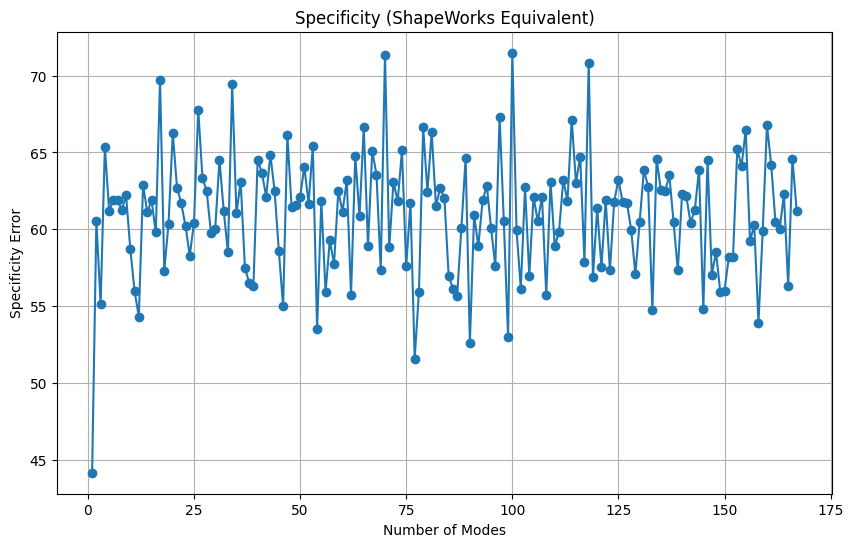

In [31]:
specificity_vals = compute_specificity_sw(real_shapes, num_samples=100)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(specificity_vals)+1), specificity_vals, marker='o')
plt.xlabel('Number of Modes')
plt.ylabel('Specificity Error')
plt.title('Specificity (ShapeWorks Equivalent)')
plt.grid(True)
plt.show()

### C. Vérification qu'avec la forme réelle, l'erreur est toujours 0

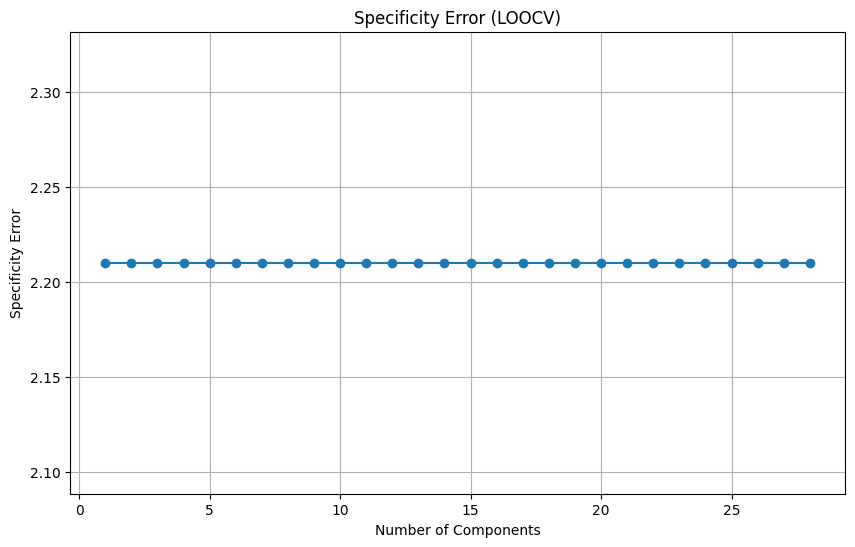

In [9]:
def loocv_error(real_shapes, eigenvectors, num_components, num_samples):
    total_error = 0
    mean_shape = np.mean(real_shapes, axis=0)  

    for i, shape in enumerate(real_shapes):
        
        leave_out_shapes = np.delete(real_shapes, i, axis=0)

        
        synthetic_shapes = real_shapes

        errors = []
        for synthetic in synthetic_shapes:
            # Center the shapes 
            centered_synthetic = synthetic - mean_shape
            centered_leave_out_shapes = leave_out_shapes - mean_shape  # Center the remaining shapes

            # Calculate the distance between the synthetic shape and all remaining real shapes
            distances = [np.linalg.norm(centered_synthetic - real) for real in centered_leave_out_shapes]
            
            # Take the minimum distance between the synthetic shape and the remaining real shapes
            min_distance = min(distances)
            errors.append(min_distance)

        # Add the mean error for this iteration
        total_error += np.mean(errors)

    # Compute the mean error across all LOOCV iterations
    mean_error = total_error / len(real_shapes)
    return mean_error


real_shapes = load_shapes(PARTICLES) 
eigenvectors = load_eigenvectors(PCA_RESULTS) 
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])  # Normalize eigenvectors

max_components = eigenvectors.shape[0]  # Maximum number of components available
num_samples = 100  # Number of synthetic shapes to generate

specificity_errors = []

# Iterate over different numbers of components and compute specificity error
for num in range(1, max_components + 1):
    error = loocv_error(real_shapes, eigenvectors, num, num_samples)
    specificity_errors.append(error)

# Plot the specificity error against the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), specificity_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Specificity Error')
plt.title('Specificity Error (LOOCV)')
plt.grid(True)
plt.show()

### 3. Generalization Error

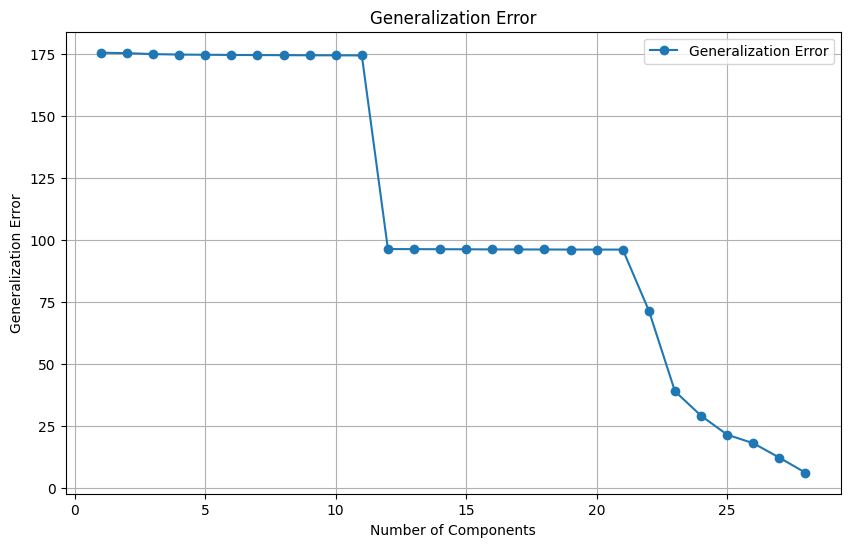

In [10]:
def calculate_generalization(real_shapes, eigenvectors, max_components):
    
    errors_by_components = []

    for num_components in range(1, max_components + 1):
        total_error = 0

        # "leave-one-out"
        for i, shape in enumerate(real_shapes):
            leave_out_shapes = np.delete(real_shapes, i, axis=0)

            # New mean shape
            mean_shape_new = np.mean(leave_out_shapes, axis=0)

            # Riconstruction of the shape
            delta_shape = shape - mean_shape_new
            reconstructed_shape_centered = np.zeros_like(delta_shape)
            for j in range(num_components):
                coefficient = np.dot(delta_shape.flatten(), eigenvectors[j].flatten())
                reconstructed_shape_centered += coefficient * eigenvectors[j]

            # Error for the current shape (delta_shape)
            error = np.linalg.norm(delta_shape - reconstructed_shape_centered)
            total_error += error

        mean_error = total_error / len(real_shapes)
        errors_by_components.append(mean_error)

    return errors_by_components

real_shapes = load_shapes(PARTICLES)
eigenvectors = load_eigenvectors(PCA_RESULTS)
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])

# Global mean shape
mean_shape = np.mean(real_shapes, axis=0)

# Leave One Out Cross Validation
max_components = eigenvectors.shape[0]
generalization_errors = calculate_generalization(
    real_shapes, eigenvectors, max_components
)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), generalization_errors, marker='o', label="Generalization Error")
plt.xlabel('Number of Components')
plt.ylabel('Generalization Error')
plt.title('Generalization Error')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
def compute_generalization_sw(real_shapes):
    M = np.column_stack(real_shapes)
    n = M.shape[1]
    d = M.shape[0]
    if n <= 1:
        return np.array([])
    generalizations = np.zeros(n - 1)
    for leave in range(n):
        Y = np.zeros((d, n - 1))
        Y[:, :leave] = M[:, :leave]
        Y[:, leave:] = M[:, leave+1:]
        mu = np.mean(Y, axis=1, keepdims=True)
        Y_centered = Y - mu
        U, S, Vt = np.linalg.svd(Y_centered, full_matrices=False)
        for mode in range(1, n):
            epsi = U[:, :mode]
            betas = epsi.T @ (M[:, leave:leave+1] - mu)
            rec = epsi @ betas + mu
            if d % 3 == 0:
                num_particles = d // 3
                diff = rec.reshape(num_particles, 3) - M[:, leave].reshape(num_particles, 3)
                dist = np.sum(np.linalg.norm(diff, axis=1)) / num_particles
            else:
                diff = rec - M[:, leave:leave+1]
                dist = np.linalg.norm(diff, axis=0).sum() / d
            generalizations[mode - 1] += dist
    generalizations /= n
    return generalizations

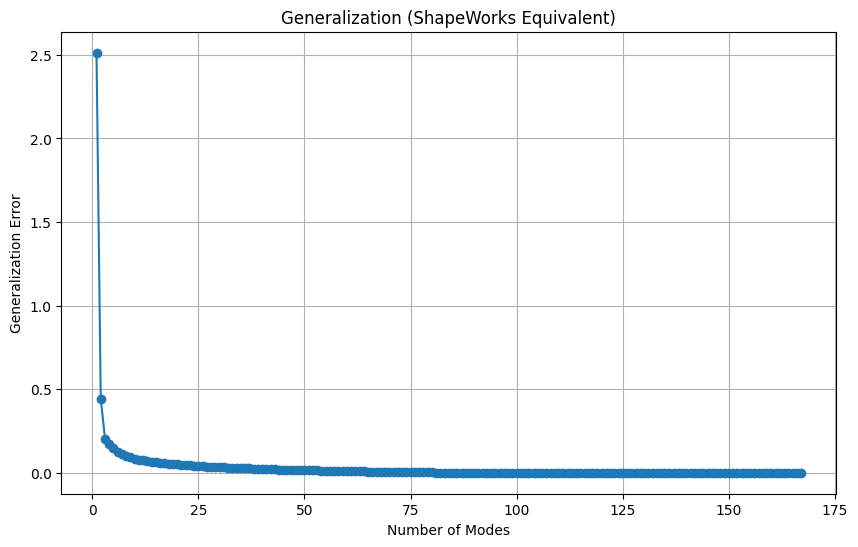

In [33]:
generalization_vals = compute_generalization_sw(real_shapes)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(generalization_vals)+1), generalization_vals, marker='o')
plt.xlabel('Number of Modes')
plt.ylabel('Generalization Error')
plt.title('Generalization (ShapeWorks Equivalent)')
plt.grid(True)
plt.show()